# Support Vector Machines

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as nplin
from sklearn.svm import SVC as csvm
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import decisionTree as dt
import time as t
import warnings

**Generating Toy Data**: let us generate a similar dataset on which we found that LwP struggled and required a carefully chosen metric to perform well. However, since the LwP algorithm, with two prototypes (one for each class in a binary classification setting) learns a linear classifier even if using a Mahalanobis metric, we will see that CSVM would be able to learn a good classifier directly. Note however, that CSVM can only learn a linear classifier, i.e. it would not be able to do well on non-linearly separable problems e.g. the checkerboard data.

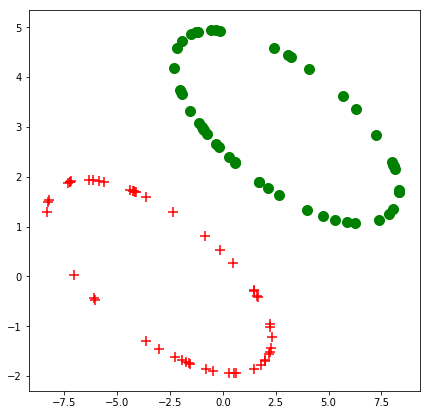

In [3]:
d = 2
n = 50

muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )
yPos = np.ones( (n,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig = pd.getFigure()
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )

**Invoking the CSVM Classifier**: the sklearn library makes it very convenient to use the CSVM classifier. Note that the invocation requires us to specify something called a _kernel_. We will study kernels in detail later. For now, we will simply use the "linear" kernel which allows us to learn linear classifiers. Note that we get perfect classification with a healthy geometric margin without having to perform metric learning which, although useful for improving the performance of LwP and NN algorithms, can be expensive too.

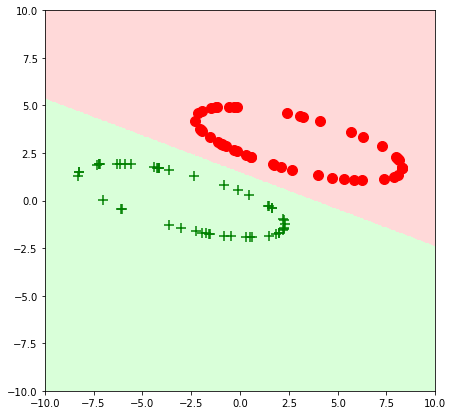

In [4]:
# clf is a popular abbreviation of the word "classifier"
clf = csvm( kernel = "linear", C = 1 )
clf.fit( X, y )
w = clf.coef_[0]
b = clf.intercept_[0]

def CSVM( X ):
    return X.dot(w) + b

fig2 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig2, mode = "batch", xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'r', marker = 'o' )

**Hyperparameters in CSVM**: the C hyperparameter in the CSVM formulation dictates how worried C-SVM gets about ensuring a large margin vs misclassifying points:
1. A very small value of C tells C-SVM that it is okay to misclassify a few points if that means that the margin will be very good on the rest of the points
1. A moderate or large value of C will politely request C-SVM to try its level best to not misclassify any point as far as possible even if it means sacrificing margin

If you have lots of data, it should not hurt to keep a moderate or large value of C. If you have less training data, it is better to keep a small value of C. In general, C is a hyperparameter that is tuned using validation

Try setting C = 0.001, 0.01, 0.1, 1, 10 and see what happens. As C increases, CSVM will get more and more  worried about misclassifying the outlier red points and will sacrifice margin in an effort to perfectly classify every data point

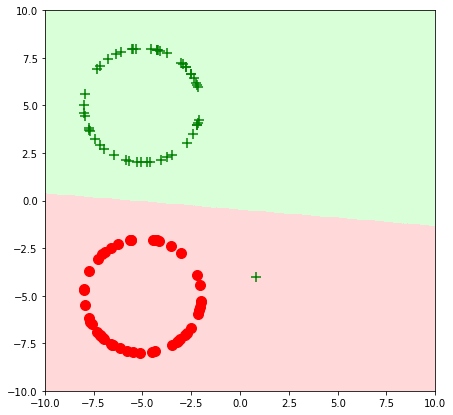

In [5]:
muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, n//30, muPos2, r//2 )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + n//30,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

clf = csvm( kernel = 'linear', C = 0.01 )
clf.fit( X, y )
w = clf.coef_[0]
b = clf.intercept_[0]

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'r', marker = 'o' )

**Building non-Linear Classifiers using CSVM**: we have only seen the use of the CSVM algorithm to learn linear classifiers. The algorithm can be used to learn non-linear classifiers as well. The most popular way of doing so is by using non-linear _kernels_ which we shall study later. However, for now let us try to do something far simpler -- use CSVM as the stump generator while learning DTs.

The following table gives a broad comparison of the trade-off offered by these two types of stumps. $d$ stands for the dimensionality of the feature vectors in the following table ($d = 2$ in our toy datasets). We note that CSVM-based stumps are more expensive than those we previously studied that considered only one feature while splitting a node. However, CSVM stumps offer much more powerful splits than single-feature stumps. Indeed some of the state-of-the-art decision trees that are used in commercial recommendation systems, do indeed use CSVM-based decision stumps to split internal nodes in the tree.

|         	|   CSVM Stump  	| Single-feature Stump 	|
|---------	|:-------------:	|:--------------------:	|
| Train   	|    Costlier   	|        Cheaper       	|
| Test    	| ${\cal O}(d)$ 	|     ${\cal O}(1)$    	|
| Storage 	| ${\cal O}(d)$ 	|     ${\cal O}(1)$    	|
| Power 	| More powerful 	|     Less powerful    	|

**Generating Toy Data**: first let us regenerate the checkerboard pattern on which we were testing our DT algorithms

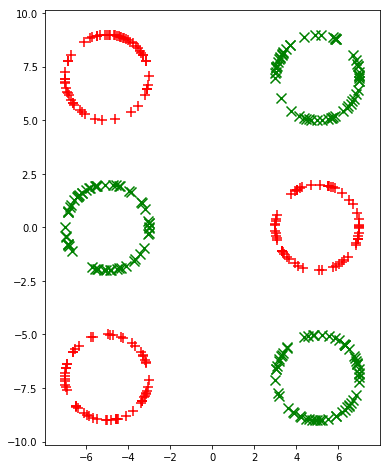

In [6]:
d = 2 
n = 60
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig4 = pd.getFigure(6,8)
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'x' )

**Building a CSVM Stump**: there may be several ways in which one can incorporate CSVMs in building decision stumps. We take a simple approach here:
1. Train a CSVM to classify the data present at a node. Since the CSVM itself tries to classify data points correctly, this automatically promotes purity of the two children nodes.
1. Once the CSVM has been trained, we should be able to use this linear classifier as a stump directly unless the CSVM has failed to learn a good classifier

There are several ways to check if CSVM has failed to split the data at a node well.
1. Check the hinge loss or the misclassification rate that CSVM is offering on the train data at this node. If these are high then CSVM has not been successful in properly sending data to the left and left and right children.
1. A cheaper way is to check the norm of the $\mathbf w$ vector returned by CSVM. If this vector is very small (say in terms of Euclidean norm), then this means that $\mathbf w^\top \mathbf x + b \approx b$ i.e. the CSVM classifier is offering a constant prediction i.e. it will recommend that almost all data be sent to one of the nodes which will give us a horrible balance factor.

If CSVM has indeed failed then we propose to (and there may be other/better ways to handle this) choose the widest dimension and split it along the median so as to promote balance (there is no point promoting purity as this node is a lost case anyway)

**Advantages of CSVM-based stumps**: note that the boundaries of the leaf cells produced by the CSVM DT are very pleasing in that they maintain as much distance from the training points as possible and the overall decision boundary mimics that of kNN almost exactly. This is because CSVM makes a serious effort to maximize the geometric margin of the classifier it learns. This is beneficial in producing good decision boundaries for the the overal DT classifier that allow it to make confident predictions.

**Potential Limitations**: although the CSVM produces very nice decision boundaries and is in general, a powerful algorithm, it is not that simple to ensure balance with the CSVM stump. This is because the CSVM algorithm makes no attempt to balance the number of data points on each side of the hyperplane. Incorporating balance is in general a difficult thing to do.

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: 
  # This is added back by InteractiveShellApp.init_path()
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: 
  # This is added back by InteractiveShellApp.init_path()


It took 0.04688 seconds to complete training the CSVM-based DT
It took 4.640625 seconds to complete testing with a CSVM-based DT


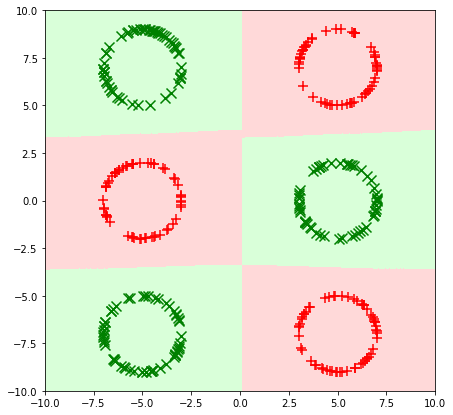

In [7]:
def getCSVMStump( X, y, ancestorSplitFeats ):
    n = y.size
    bestObjective = float('inf')
    
    clf = csvm( kernel = 'linear', C = 1.0 )
    clf.fit( X, y )
    w = clf.coef_[0]
    b = clf.intercept_[0]
    
    if nplin.norm( w, 2 ) < 1e-3:
        warnings.warn( "\nWarning: norm(w) = %0.5f -- reverting to feature stump instead" % nplin.norm( w, 2 ), UserWarning )
        # Choose the dimension along which the data is spread out the most
        bestFeat = np.argmax( np.max( X, axis = 0 ) - np.min( X, axis = 0 ) )
        temp = np.sort( X[:, bestFeat] )
        # Split at the median along that dimension to promote balance
        bestThresh = (temp[n//2 - 1] + temp[n//2 + 1])/2
        w = np.zeros_like( w )
        w[bestFeat] = 1
        b = -bestThresh
        
    return lambda data: data.dot(w) + b

maxLeafSize = 5
maxDepth = 3

dtSVM = dt.Tree( maxLeafSize, maxDepth )
tic = t.process_time()
dtSVM.train( X, y, getCSVMStump )
toc = t.process_time()
print( "It took %1.5f seconds to complete training the CSVM-based DT" % (toc - tic) )

fig5 = pd.getFigure()
tic = t.process_time()
pd.shade2D( dtSVM.predict, fig5, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete testing with a CSVM-based DT")
pd.plot2D( XNeg, fig5, color = 'r', marker = '+' )
pd.plot2D( XPos, fig5, color = 'g', marker = 'x' )